In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
import tomotopy as tp
import re
import jieba
from tqdm.notebook import tqdm
import jieba.posseg as pseg
from gensim import corpora, models

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
#文档
data=pd.read_csv(r'data/美团单车.csv')
data.head()

,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id
0,4778521149574893,LwWH0EaRL,3265173290,氢铒氧,咱就是说@美团，你是真的🐮13，我前一分钟刚取消了续费美团单车，下一分钟再找车地图上一辆都没...,NaN,NaN,"美团,美团单车","美团单车,美团",0,1,0,2022-06-09 18:48,vivo S7轻薄自拍旗舰,['https://wx3.sinaimg.cn/large/c29e972aly1h326...,NaN,NaN
1,4778204256537339,LwOrTrqEX,5094718434,胡图图好困,#美团单车#满格电车到桥上突然断电，来来往往的车一直疯狂打喇叭我把你总裁扔高速上行吗？还是上...,NaN,NaN,NaN,"美团单车,哈啰单车,小溜共享",0,0,1,2022-06-08 21:48,iPhone客户端,NaN,NaN,NaN
2,4778163853330791,LwNoJdYur,6465846943,对我有意见的话别来找我,为什么没有单车啊？？！？！都是助力车我想骑一下自行车#康巴什##哈罗单车#什么单车也行啊#美...,NaN,鄂尔多斯·水岸新城中心公园,NaN,"康巴什,哈罗单车,美团单车,青桔",0,2,0,2022-06-08 19:08,HUAWEI P40 5G,NaN,NaN,NaN
3,4778152393443608,LwN6ferQ4,6558935098,苏小婷婷儿,@美团单车我真的会谢美团，能不能整管一下系统定位？我每次从同一个地方骑出去，然后再骑回来，你...,NaN,NaN,美团单车,美团单车,0,2,1,2022-06-08 18:22,vivo Y70s 5G,['https://wx4.sinaimg.cn/large/0079SCDMgy1h310...,NaN,NaN
4,4776774423019532,LwdfIcFw8,3263230724,朱_敏轩,最近两三天开app扫车扫了告知我提示有未完成的订单但是显示的读数就是刚刚打开计时的异常上报也...,NaN,上海,NaN,美团单车,0,0,0,2022-06-04 23:07,iPhone客户端,NaN,NaN,NaN


In [3]:
data.isnull().sum()

id              0
bid             0
user_id         0
用户昵称            0
微博正文            0
头条文章url       559
发布位置          402
艾特用户          433
话题              3
转发数             0
评论数             0
点赞数             0
发布时间            0
发布工具            5
微博图片url       208
微博视频url       546
retweet_id    552
dtype: int64

In [4]:
# 只保留中文
data['微博正文']=data['微博正文'].astype('str')
data['content'] = data['微博正文'].str.replace("[^\u4e00-\u9fa5]", "")

In [5]:
# 移除常用词以及分词
stoplist = [i.strip() for i in open(r'data/stopwords.txt',encoding='utf-8').readlines()]
def segment(text):
    words = jieba.cut(text)
    words = [w for w in words if w not in stoplist if len(w)>1]
    return words

data['words'] = data['content'].apply(segment)
print("二次删除停用词和分词成功！！！")
data.head(1)

Building prefix dict from the default dictionary ...
2022-06-14 17:04:45,678 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\WIN10\AppData\Local\Temp\jieba.cache
2022-06-14 17:04:45,680 : DEBUG : Loading model from cache C:\Users\WIN10\AppData\Local\Temp\jieba.cache
Loading model cost 0.877 seconds.
2022-06-14 17:04:46,556 : DEBUG : Loading model cost 0.877 seconds.
Prefix dict has been built successfully.
2022-06-14 17:04:46,558 : DEBUG : Prefix dict has been built successfully.


删除停用词和分词成功！！！


,id,bid,user_id,用户昵称,微博正文,头条文章url,发布位置,艾特用户,话题,转发数,评论数,点赞数,发布时间,发布工具,微博图片url,微博视频url,retweet_id,content,words
0,4778521149574893,LwWH0EaRL,3265173290,氢铒氧,咱就是说@美团，你是真的🐮13，我前一分钟刚取消了续费美团单车，下一分钟再找车地图上一辆都没...,NaN,NaN,"美团,美团单车","美团单车,美团",0,1,0,2022-06-09 18:48,vivo S7轻薄自拍旗舰,['https://wx3.sinaimg.cn/large/c29e972aly1h326...,NaN,NaN,咱就是说美团你是真的我前一分钟刚取消了续费美团单车下一分钟再找车地图上一辆都没有了我以为是下...,"[美团, 真的, 我前, 一分钟, 取消, 续费, 美团, 单车, 一分钟, 找车, 地图,..."


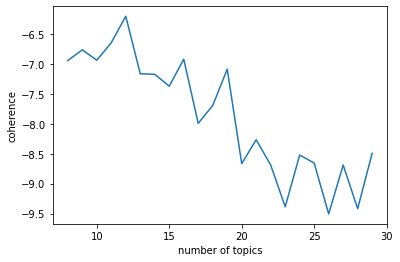

In [6]:
#查询主题个数比较合适
def find_k(docs, min_k, max_k, min_df):
    #min_df 词语最少出现在2个文档中
    import matplotlib.pyplot as plt
    scores = []
    for k in range(min_k, max_k):
        #seed随机种子，保证运行的结果一样
        mdl = tp.LDAModel(min_df=min_df, k=k,seed=555)
        for words in docs:
            if words:
                mdl.add_doc(words)
        mdl.train(20)
        coh = tp.coherence.Coherence(mdl)
        scores.append(coh.get_score())

    #x = list(range(min_k, max_k - 1))  # 区间最右侧的值。注意：不能大于max_k
    #print(x)
    #print()
    plt.plot(range(min_k, max_k), scores)
    plt.xlabel("number of topics")
    plt.ylabel("coherence")
    plt.show()    
    
find_k(docs=data['words'], min_k=8, max_k=30, min_df=2)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
# 将文本中的词语转换为词频矩阵
cleanchap = [" ".join(w) for w in data['words']]

Tfidfvectorizer =TfidfVectorizer(max_df=0.4, 
                             min_df=2, 
                             max_features=2000,stop_words=stoplist) #创建词袋数据结构
data_vectorized = Tfidfvectorizer.fit_transform(cleanchap)

In [8]:
pd.DataFrame(data_vectorized.toarray(),columns=Tfidfvectorizer.get_feature_names()).to_csv('data/美团单车_Tfidf.csv',encoding='utf_8_sig')

In [9]:
# 设定LDA模型
from sklearn.decomposition import LatentDirichletAllocation
n_topics=14
ldamodel = LatentDirichletAllocation(n_components = n_topics)
ldamodel.fit(data_vectorized)

LatentDirichletAllocation(n_components=14)

In [10]:
# 主题词打印函数
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
n_top_words = 12
tf_feature_names = Tfidfvectorizer.get_feature_names()
print_top_words(ldamodel, tf_feature_names, n_top_words)

Topic #0:
黄车 青桔 高峰 共享 区域 地铁站 可用 广东 早上 客服 深圳 几天
Topic #1:
骑行 摩拜 共享 拼团 哈啰 手机号 直充 卡天 限次 青桔 网络 新开
Topic #2:
一辆 迟到 武汉 两块钱 发现 停车位 自行车 违停 开美团 显示 垃圾 发布
Topic #3:
垃圾 迟到 上班 客服 服务器 素质 回去 手机 学校 还车 车点 崩溃
Topic #4:
自行车 每次 哈罗 青桔 快来 真的 一个月 骑车 地方 黄美团 摩拜 管管
Topic #5:
早上 一周 骑车 扫不开 无语 單車 出行 停车 共享 分钟 美團 坐垫
Topic #6:
操作 骑行 为啥 半天 助力车 青桔 早上 链接 调度 免费 颜值 复工
Topic #7:
拼团 广州 停车 马路 分钟 定位 电单车 有人 拼车 骑行 摩拜 收费
Topic #8:
微博 视频 拼团 出门 整天 四个 定位 锁好 一辆 姐妹 无语 停车
Topic #9:
拼团 天津 一个月 成都 违停 小可爱 骑美团 显示 运营 申诉 举报 提示
Topic #10:
共享 美团单 周卡 地铁站 朋友 发现 一辆 希望 摩拜 路上 一台 骑车
Topic #11:
有没有 拼团 摩拜 早上 车骑 两个 涨价 破坏 骑行 拼美团 情况 真的
Topic #12:
停车 客服 不到 锁车 骑车 车辆 位置 共享 电话 下班 差点 王兴
Topic #13:
摩拜 更名 西安 公里 提示 共享 服务 差人 消毒 官微 黄车 运营



In [11]:
import joblib
joblib.dump(ldamodel, r'data/model_2.pkl')

['D:\\Case\\标贝\\6.15\\model_2.pkl']

In [12]:
import numpy as np

# 构建文档-词频矩阵
lda_output = ldamodel.transform(data_vectorized)
# 列名
topicnames = ["Topic" + str(i) 
              for i in range(ldamodel.n_components)]
# 行索引名
#docnames = ["Doc" + str(i) for i in range(len(data.words))]

# 转化为pd.DataFrame
df_document_topic = pd.DataFrame(np.round(lda_output, 4), 
                                 columns=topicnames, 
                                 index=data['bid'])

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [13]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,dominant_topic
bid,,,,,,,,,,,,,,,
LwWH0EaRL,0.0184,0.0184,0.7604,0.0184,0.0184,0.0184,0.0184,0.0184,0.0184,0.0184,0.0184,0.0184,0.0184,0.0184,2
LwOrTrqEX,0.0138,0.0138,0.0138,0.0138,0.0138,0.0138,0.0138,0.0138,0.0138,0.0138,0.8201,0.0138,0.0138,0.0138,10
LwNoJdYur,0.0240,0.0240,0.0240,0.0240,0.6886,0.0240,0.0240,0.0240,0.0240,0.0240,0.0240,0.0240,0.0240,0.0240,4
LwN6ferQ4,0.0144,0.0144,0.0144,0.0144,0.4936,0.0144,0.0144,0.0144,0.0144,0.0144,0.0144,0.0144,0.3342,0.0144,4
LwdfIcFw8,0.0221,0.0221,0.0221,0.0221,0.0221,0.0221,0.0221,0.0221,0.0221,0.7126,0.0221,0.0221,0.0221,0.0221,9


In [14]:
result_data=pd.merge(data,df_document_topic,on='bid')

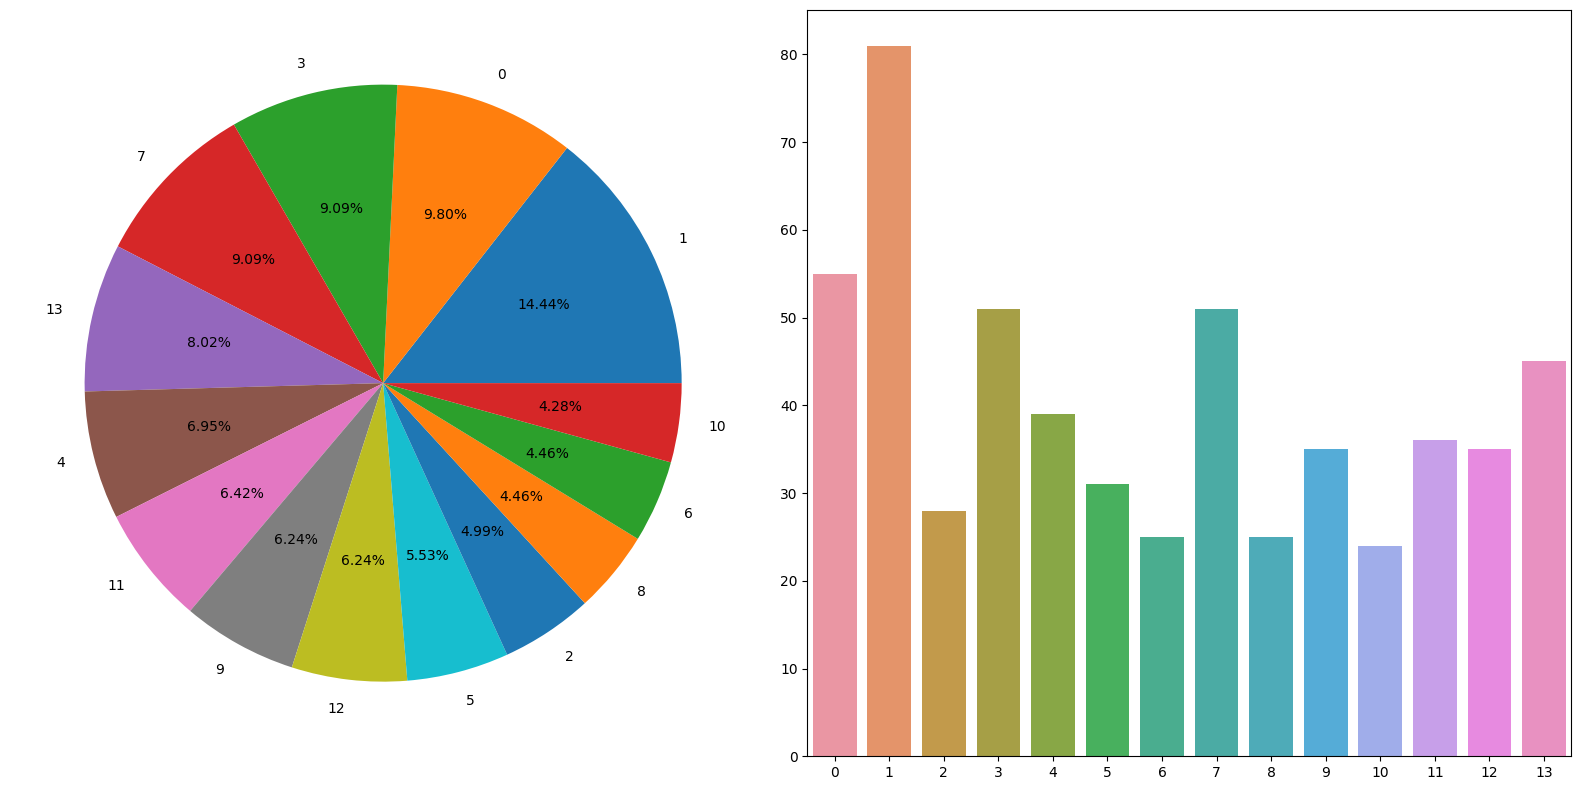

In [15]:
# 主题分布图
import seaborn as sns 
result_type_counts = result_data['dominant_topic'].value_counts()
fig,axes = plt.subplots(1,2,figsize=(16,8),dpi=100)
axes[0].pie(result_type_counts.values,autopct="%.2f%%",labels=result_type_counts.index)
sns.barplot(result_type_counts.index,result_type_counts.values)
plt.savefig(r'data/美团单车_主题分布图.png')
plt.tight_layout()

In [16]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,81
1,0,55
2,3,51
3,7,51
4,13,45
5,4,39
6,11,36
7,9,35
8,12,35
9,5,31


In [17]:
result_data.to_csv('data/美团单车_data.csv',encoding='utf_8_sig')